First we import all neccessary packages

In [2]:
import iss, isstorch
import torch, numpy
from tqdm import trange
from utils import generate_examples, compute_signatures

import torch.nn as nn
from torch.optim import Adam

from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt

In [6]:
x = torch.randn(1000, 100, device="cuda")
%time isstorch.compute(x)
%time iss.compute(x.numpy())

AssertionError: Torch not compiled with CUDA enabled

Let's look at some samples. The function `generate_samples` outputs a different set of data each time.

CPU times: user 9.53 ms, sys: 2 ms, total: 11.5 ms
Wall time: 9.43 ms


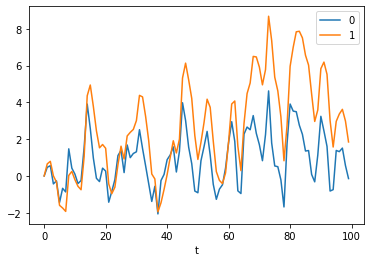

In [2]:
%time X, labels = generate_examples()
plt.plot(range(100), X[0], label=labels[0].item())
plt.plot(range(100), X[500], label=labels[500].item())
plt.xlabel('t')
plt.legend()
plt.show()

Now, we compute the signatures using our `pytorch` implementation

In [3]:
%time sigs = compute_signatures(X)

CPU times: user 71.3 ms, sys: 1.22 ms, total: 72.5 ms
Wall time: 71.5 ms


In order to train and test our Neural Network, we need to wrap the data in a PyTorch `DataLoader`. We also load the training data in batches of 6 samples.

In [56]:
dataset = TensorDataset(sigs, labels)
train_dataset, test_dataset = random_split(dataset, [700, 300])
train_dataloader = DataLoader(train_dataset, batch_size=100)
test_dataloader = DataLoader(test_dataset, batch_size=10)

Now, we build our model using by subclassing `torch.nn.Module`. We use a stack of dense layers with ReLU activation. To see all possible layers and activations, please see the `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).

In [52]:
class DenseNet(nn.Module):
    def __init__(self, hidden_layers=1, width=10):
        super().__init__()
        input_layer = nn.Sequential(
            nn.Linear(in_features=3, out_features=width),
            nn.ReLU()
        )
        layers = [input_layer]
        for k in range(hidden_layers):
            layers.append(nn.Sequential(
                nn.Linear(in_features=width, out_features=width),
                nn.ReLU()
                )
            )
        
        layers.append(nn.Sequential(
            nn.Linear(in_features=width, out_features=2),
            nn.Tanh()
            )
        )
        self.stack = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.stack(x)

Next, we set up the training and testing loops

In [44]:
def train_loop(model, dataloader, loss_fn, optimizer):
    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(model, dataloader, loss_fn):
    total_samples = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return correct/total_samples * 100, test_loss / total_samples

Setup our model, loss function and optimizer. Train the network and output the result.

In [57]:
model = DenseNet(hidden_layers=20, width=30)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

epochs = 100
with trange(epochs) as pbar:
    for t in pbar:
        train_loop(model, train_dataloader, loss_fn, optimizer)
        acc, avg_loss = test_loop(model, test_dataloader, loss_fn)
        pbar.set_description(f"Epoch {t+1}")
        pbar.set_postfix(loss=avg_loss, accuracy=acc)

acc, avg_loss = test_loop(model, test_dataloader, loss_fn)
print(f"Done! Accuraccy: {acc}, Average Loss: {avg_loss:.>3f}")

Epoch 100: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.78it/s, accuracy=71, loss=0.0532]

Done! Accuraccy: 71.0, Average Loss: 0.053156
